Using Selenium to achieve automated Google search to scrape lyrics online.

Acknowledgment

This Python notebook was made by Solomon Kit Shing Ho (kshingho@connect.hku.hk) in October 2023.

Prepared exclusively for BA(HDT) coding session "Tech Thursday: Code & Connect".

Last Updated: 10 October, 2023

This Python notebook is then further adapted by Wong Yu, Cole (cwy1013@connect.hku.hk) in October 2023 for research purposes.

Any block that isn't importing or Selenium is written by Wong Yu, Cole.

You can expand each collapsed block to reveal the Python scripts used, and their preliminary outputs.

Reload the blocks at your own discretion, as some of them are dependent on files existing on my own repository.

Last Updated: 19 October, 2023

<h1>Sam-Sung: An Introductory Historical Analysis on Sam Hui's Lyrical Styles</h1>

Please refer to the last section, The Rationale (For Grading Purposes), for the required rationale which is strictly under the word limit of not being more than 200 words.

<h2>Topic Synopsis</h2>
Sam Hui was an influential singer, composer, and actor, who is often dubbed the 'God of Song' in Cantopop. 

However, across his wide catalog of songs, both written and performed, there are obvious stylistic differences that while obvious to listeners, may be difficult to articulate with precision. For example, while one can tell that Sam shifted to more romantic songs during the 1980s, it is still difficult to contrast it with his earlier romance songs; with at least 101 songs performed (Universal Music Ltd., 2011) and more written by him, listeners may struggle to grasp details of his musical style since his debut in the 1970s.

Therefore, I hope to contribute to this discussion by attempting to provide quantitative evidences on Cantonese songs published directly under his name up until 2007 to support conclusions that move past personal impressions, and allow for more empirical understandings on this monumental figure in Hong Kong history.

<h2>Choices of Tool</h2>

<h3>BeautifulSoup</h3>

I will use BeautifulSoup to scrap a list of songs for Selenium to process on.

<h3>Selenium</h3>

I will mainly be using Selenium as it allows me to scrap the internet across various websites for lyrics.

<h3>Pandas</h3>

I will use Pandas for data management and visualisation.

<h3>ChatGPT</h3>

I will also feed each song's lyrics into ChatGPT for preliminary categorisation as preparation for Distant Reading.

<h3>Voyant Tools</h3>

I will use Voyant-tools.org to trace the most frequent terms used by Sam Hui.

In [ ]:
!pip install requests requests_html selenium beautifulsoup4 tqdm

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
import time
import csv
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import TimeoutException

In [3]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
from requests_html import HTMLSession
import urllib.parse
import requests
import pandas as pd
import re

from csv import writer

<h2>Preparing his Musical Catalog</h2>

With such an extensive list of musical compositions, the first part would be to gather a comprehensive list of songs related to him.

<h3>Data Curation</h3>
I will first extract a basic list of songs from the relatively clean Wikipedia page 許冠傑音樂專輯列表 (https://zh.wikipedia.org/wiki/許冠傑音樂專輯列表). Due to time constraints this will be my only reference, and songs beyond this list will not be considered within the project scope.

Due to time contraints, I will also omit English songs despite them appearing on the wikipedia page too, as they are largely popular Western songs sung by Sam rather than compositions curated for him. However, relevant data, albeit incomplete, will still be available upon request.

Then, I will scrap the more detailed webpage (https://mojim.com/ush101187-A2.htm) for additional information, and make manual adjustments to ensure consistency. Any extra songs picked up here will be stored in a seperate unorganised database, and can also be provided upon request.

Note that I explicitly will not include songs Sam Hui composed for Rick Hui, his brother, and others due to time constraints, but future researchers may look into them at their own discretion.



In [10]:
url= "https://zh.wikipedia.org/wiki/許冠傑音樂專輯列表"
webpage1 = requests.get(url)
soup1 = BeautifulSoup(webpage1.content, 'html.parser')

lists = soup1.find_all('table', class_='wikitable')

In [ ]:
wiki = [] #We will now scrap the Wikipedia page with manual input (don't rerun!)
tab = 0
for i in lists:
    j = i.find_all("tr")
    for k in j:
        Date = k.find("th")
        DateT = Date.get_text()
        if DateT != "出版日期\n":
            DateS = DateT.split('年')
            Year = int(DateS[0])
            #print(Year)

            t = k.find_all("td")
            AlbumName = t[0].get_text().strip("\n ")
            #print(AlbumName)

            l = k.find_all("li") #Extracting all the song names out

            AlbumType = "Full"
            if tab == 2:
                if len(l) == 1:
                    AlbumType = "Single"
                else:
                    AlbumType = "Extended Play"
            #print(AlbumType)

            RecordLabelT = t[1].get_text().strip("\n").split("、")
            RecordLabels = ";".join(RecordLabelT)
            #print(RecordLabels)

            for s in l:
                small = s.find("small")
                Artists = "許冠傑"
                Medley = ""
                if not small:
                    SongP = s.get_text().strip("）\n").split('（')
                    SongName = SongP[0]
                    #print(SongName)
                    
                    if len(SongP) > 1:
                        if SongP[1] == "音樂":
                            SongName = SongName + '(' + SongP[1] + ')'
                            Artists = "Instrumental"
                        else:
                            if SongP[0] == "鬼馬大家樂":
                                Medley = ";".join(SongP[1].split("、"))
                            else:
                                SongName = SongName + '(' + SongP[1] + ')'  
                                #print(SongName)   
                else:
                    SongP = s.get_text().strip("）\n").split('（')
                    SongName = SongP[0].replace(small.get_text(),"")
                    SongName = SongName[:-1]
                    #print(SongName)
                    if SongName == "繼續微笑" or SongName == "'04 祝福你" or SongName == "誰在你心裡":
                        Artists += ";Sam's Angels,2004"
                    elif SongName == "鐘聲響起":   
                          Artists += ";許懷欣(Rap);許懷谷(Rap)"        
                    else:
                        print(SongName, end=":")
                        print(Artists, end=";")
                        print(small.get_text().strip("()（）\n "), end=";")
                        Artists = input(small.get_text())
                        print("")
                
                wiki.append({
                    "Year": Year,
                    "Album Names": AlbumName,
                    "Album Type": AlbumType,
                    "Record Label(s)": RecordLabels,
                    "Song Name": SongName,
                    "Medley": Medley,
                    "Artist(s)": Artists,
                    "Composer(s)": "",
                    "Lyricist(s)": ""
                })
            #print("\n")
        else:
            print("\nBegin parsing table...\n")
    tab += 1

In [ ]:
wiki #You may run this to display the entire Wikipedia list

In [26]:
import copy

In [168]:
moji = copy.deepcopy(wiki) #This will be the table which we work on for scraping on mojim.com

In [ ]:
moji

In [119]:
url= "https://mojim.com/ush101187-A2.htm"
webpage2 = requests.get(url)
soup2 = BeautifulSoup(webpage2.content, 'html.parser')

lists = soup2.find('dl', class_='ha0')

In [ ]:
lists

In [169]:
def SearchMoji(SongName, Composers, Lyricists):
    Place = 0
    Flag = False
    while Place < len(moji):
        if moji[Place]["Song Name"] == SongName:
            if Composers != "\u3000":
                moji[Place]["Composer(s)"] = Composers 
            if Lyricists != "\u3000": 
                moji[Place]["Lyricist(s)"] = Lyricists
            Flag = True
        Place += 1
    if Flag:
        return 69
    else: 
        return -69
            
    

In [ ]:
mojim = [] #This extra list is to store new items from mojim.com for manual input
hb2 = lists.find_all("dd", class_ = "hb2")
hb3 = lists.find_all("dd", class_ = "hb3")

for hbb in hb2:
    SongName = hbb.find("a").get_text()

    Composers = ";".join(hbb.find("span", class_ = "hc3").get_text().split('/'))
    Lyricists = ";".join(hbb.find("span", class_ = "hc2").get_text().split('/'))
    print(SongName, Composers, Lyricists)
    if SearchMoji(SongName, Composers, Lyricists) == -69:
        Year = 0
        YearT = hbb.find("span", class_ = "hc4").get_text().split('-')[0]
        if YearT != "　":
            Year = int(YearT)
        mojim.append({
            "Year": Year,
            "Album Names": "",
            "Album Type": "",
            "Record Label(s)": "",
            "Song Name": SongName,
            "Medley": "",
            "Artist(s)": "許冠傑",
            "Composer(s)": Composers,
            "Lyricist(s)": Lyricists
        })

for hbb in hb3:
    SongName = hbb.find("a").get_text()

    Composers = ";".join(hbb.find("span", class_ = "hc3").get_text().split('/'))
    Lyricists = ";".join(hbb.find("span", class_ = "hc2").get_text().split('/'))
    print(SongName, Composers, Lyricists)
    if SearchMoji(SongName, Composers, Lyricists) == -69:
        Year = 0
        YearT = hbb.find("span", class_ = "hc4").get_text().split('-')[0]
        if YearT != "　":
            Year = int(YearT)
        mojim.append({
            "Year": Year,
            "Album Names": "",
            "Album Type": "",
            "Record Label(s)": "",
            "Song Name": SongName,
            "Medley": "",
            "Artist(s)": "許冠傑",
            "Composer(s)": Composers,
            "Lyricist(s)": Lyricists
        })

In [159]:
Place = 0 #Correcting an inconsistency I found on the way
while Place < len(moji):
    if moji[Place]["Song Name"] == '宇宙無限 Instrumental':
        moji[Place]["Artist(s)"] = 'Instrumental'
    Place += 1

In [ ]:
moji #Note how our dataset is still incomplete

In [ ]:
mojim #As you can see, a lot of the 'unmarked' songs are trivial

In [ ]:
mojimTBC = [] #We will now filter out the unwanted duplicates
for i in mojim:
    if input(i["Song Name"]) == "1":
        print("Adding " + i["Song Name"])
        mojimTBC.append({
            "Year": i["Year"],
            "Album Names": "",
            "Album Type": "",
            "Record Label(s)": "",
            "Song Name": i["Song Name"],
            "Medley": "",
            "Artist(s)": i["Artist(s)"],
            "Composer(s)": i["Composer(s)"],
            "Lyricist(s)": i["Lyricist(s)"]
        })

In [ ]:
#After filtering the above list for 20 minutes, I decided to save everything first
mojimTBCpd = pd.DataFrame(mojimTBC)
print(mojimTBCpd)
mojimTBCpd.to_csv('SamHui-Catalog-ToBeAdded.csv',  encoding='utf_8_sig')

In [ ]:
mojipd = pd.DataFrame(moji)
print(mojipd)
mojipd.to_csv('SamHui-Catalog-List-Step2.csv',  encoding='utf_8_sig')

In [ ]:
wikipd = pd.DataFrame(wiki)
print(wikipd)
wikipd.to_csv('SamHui-Catalog-List-Step1.csv',  encoding='utf_8_sig')

<h3>Manual Processing</h3>

After some manual data processing on a spreadsheet view of the .csv files, I have finally finished preparing his music catalog based on Wikipedia.

In [194]:
lcl = [] #This is the final list
with open('SamHui-Catalog-List.csv', 'r',encoding='utf-8') as file:
    reader = csv.reader(file)
    for row in reader:
        lcl.append({
            "Year": row[1],
            "Album Names": row[2],
            "Album Type": row[3],
            "Record Label(s)": row[4],
            "Song Name": row[5],
            "Medley": row[6],
            "Artist(s)": row[7],
            "Composer(s)": row[8],
            "Lyricist(s)": row[9]
        })
lcl.pop(0)
print(lcl)

[{'Year': '1974', 'Album Names': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '雙星情歌', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠傑', 'Lyricist(s)': '許冠傑'}, {'Year': '1974', 'Album Names': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '鬼馬雙星', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠傑', 'Lyricist(s)': '許冠傑'}, {'Year': '1974', 'Album Names': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '甜蜜伴侶', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠英', 'Lyricist(s)': '許冠英'}, {'Year': '1974', 'Album Names': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '無情夜冷風', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠英', 'Lyricist(s)': '許冠英'}, {'Year': '1974', 'Album Names': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '一水隔天涯／愛你三百六十年', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '于粦;川口真', 'Lyricist(s)': '許冠傑'}, {'Year': '1974', 'Album Names': '鬼馬雙星', 'Album

In [195]:
cl = pd.DataFrame(lcl)

In [196]:
cl #The table is shown as follows

,Year,Album Names,Album Type,Record Label(s),Song Name,Medley,Artist(s),Composer(s),Lyricist(s)
0,1974,鬼馬雙星,Full,寶麗多,雙星情歌,,許冠傑,許冠傑,許冠傑
1,1974,鬼馬雙星,Full,寶麗多,鬼馬雙星,,許冠傑,許冠傑,許冠傑
2,1974,鬼馬雙星,Full,寶麗多,甜蜜伴侶,,許冠傑,許冠英,許冠英
3,1974,鬼馬雙星,Full,寶麗多,無情夜冷風,,許冠傑,許冠英,許冠英
4,1974,鬼馬雙星,Full,寶麗多,一水隔天涯／愛你三百六十年,,許冠傑,于粦;川口真,許冠傑
...,...,...,...,...,...,...,...,...,...
288,1986,宇宙無限,Extended Play,新藝寶,Radio好知己,,許冠傑,Mike Hawker;Ivor Raymonde,林振強
289,1989,珍惜.....往日情,Extended Play,新藝寶,往日情(現場版),,許冠傑,許冠傑,許冠傑;薛志雄
290,1989,珍惜.....往日情,Extended Play,新藝寶,兩個世界(現場版),,許冠傑,大津彰;鈴木喜三郎,向雪懷
291,1989,珍惜.....往日情,Extended Play,新藝寶,沉默是金,,許冠傑,張國榮,許冠傑


<h2>Compiling his Music Catalog</h2>
Now that we have a list of songs to analyse, I will then collect further information for each of them.

<h3>Data Format</h3>
I stored these aspects of data in such formats:

1. Year (Integer)

    This will serve as the main axis to track Sam Hui's music style against.
    
    However, I cannot include the full date due to inconsistent data provided for each album.
    

2. Album Name (String)

    This helps distinguish between repeated entries.

3. Album Type (String, "Full"/"Single"/"Extended Play")

    This helps identify the nature of Sam Hui's publication, potentially: commercial, or more experimental?

4. Record Label(s) (String, seperated by ';')

    This helps identify potential influences by the Record Labels over his lyrical composition.

5. Song Name (String)

    This helps identify repeated entries.

6. Medley (String, seperated by ';')

    This will also allow cross-referencing of songs to be highlighted.

7. Artist(s) (String, seperated by ';')
    
    "Instrumental" denotes an instrumental piece.

    (Rap) denotes rapping, while "Sam's Angels,2004" denotes the children choir he had for the 2004 album 歌神與您繼續微笑 '04.
    
    Otherwise, you may assume that it's a balanced joint effort.

8. Composer(s) (String, seperated by ';')

9. Lyricist(s) (String, seperated by ';')

    "Instrumental" denotes an instrumental piece.

10. Adapted from (String)

    A major feature of early cantopop is that a lot of songs are adapted from foreign originals, such that this is a non-neglectable dimension of analysis.

11. Originally Sang by (String)

    This is collected as Elvis Presley's songs clearly influenced Sam Hui's musical style and career, especially through direct adaptations by the latter.

12. Movie (String)

    This is collected as Sam Hui's career as an actor also potentially influenced his stylistic design of music pieces.

13. Movie Role (String)

    This allows for a more informed consideration for the previous item.

14. Lyrics (String)

    By-part lyrics are denoted by _：, eg. 男：... 

    While I did some basic manual verification, the text are largely unaltered as I cannot personally verify all data entries such that data integrity may be important for backtracing in the future.

15. Source(s) (String)

    This allows for backtracing in case of a faulty entry being discovered later on.

All names should either be written in normal Chinese character order (許冠傑), or in English by its most expanded form.

The Chinese form is preferred for both Chinese and Japanese individuals such that the English form denotes Western influence.

English words, unless an abbreviation, should all be capitalised only by their first letter.

An empty slot denotes null data as all unfound data has been manually dealt with.

Overall, ';' is preferred as a seperation symbol due to its rarity in normal meta data, while having a more distinct meaning than a comma, a white space, or a full stop.


In [ ]:
info = [] #This is where we'll store the lryics from KKBox!

search_terms = [s["Song Name"] + ' ' + s["Artist(s)"] + ' ' + 'KKBOX' for s in lcl]
driver = webdriver.Chrome()

for term in search_terms:
    driver.get('https://www.google.com/')
    search_box = driver.find_element(By.NAME, 'q')
    search_box.send_keys(term)
    search_box.send_keys(Keys.RETURN)
    
    try:
        el = WebDriverWait(driver,2).until(
            EC.presence_of_element_located((By.CSS_SELECTOR,"a[href*='kkbox.com/hk/en/']"))
        )
        el.click()
        driver.get(driver.current_url)
        webs = driver.find_elements(By.XPATH, '/html/body/main')
        for web in webs:
            title = web.find_element(By.CLASS_NAME,'title').text
            artist = web.find_element(By.CLASS_NAME,'artist').text
            album = web.find_element(By.CLASS_NAME,'inner').text
            lyrics = web.find_element(By.CLASS_NAME,'lyrics').text
            date = web.find_element(By.CLASS_NAME, 'release').text
            source = 'KKBOX.com'
            
    except NoSuchElementException:
        try:
            el = WebDriverWait(driver,2).until(
            EC.presence_of_element_located((By.CSS_SELECTOR,"a[href*='kkbox.com/hk/']"))
            )
            el.click()
            driver.get(driver.current_url)
            webs = driver.find_elements(By.XPATH, '/html/body/main')
            for web in webs:
                title = web.find_element(By.CLASS_NAME,'title').text
                artist = web.find_element(By.CLASS_NAME,'artist').text
                album = web.find_element(By.CLASS_NAME,'inner').text
                lyrics = web.find_element(By.CLASS_NAME,'lyrics').text
                date = web.find_element(By.CLASS_NAME, 'release').text
                source = 'KKBOX.com'
        except:
            time.sleep(2)
            driver.back()
            title = term.split()[0]
            source = 'Not Found'
            lyrics = 'Not Found'
            
    except TimeoutException:
        try:
            el = WebDriverWait(driver,2).until(
            EC.presence_of_element_located((By.CSS_SELECTOR,"a[href*='kkbox.com/hk/']"))
            )
            el.click()
            driver.get(driver.current_url)
            webs = driver.find_elements(By.XPATH, '/html/body/main')
            for web in webs:
                title = web.find_element(By.CLASS_NAME,'title').text
                artist = web.find_element(By.CLASS_NAME,'artist').text
                album = web.find_element(By.CLASS_NAME,'inner').text
                lyrics = web.find_element(By.CLASS_NAME,'lyrics').text
                date = web.find_element(By.CLASS_NAME, 'release').text
                source = 'KKBOX.com'
        except:
            time.sleep(2)
            driver.back()
            title = term.split()[0]
            source = 'Not Found'
            lyrics = 'Not Found'
        
    web_item = {
                'Source':source,
                'Date':date,
                'Artist':artist,
                'Title':title,
                'Album':album,
                'Lyrics':lyrics 
            }
    
    info.append(web_item)
    time.sleep(2)
    driver.back()
df = pd.DataFrame(info)
print(df)

df.to_csv('SamHui-Lyrics-KKBox.csv',  encoding='utf_8_sig')

In [ ]:
infoM = [] #This is where we'll store the lryics from Mojim!

search_terms = [s["Song Name"] + ' ' + s["Artist(s)"] + ' ' + 'mojim' for s in lcl]
driver = webdriver.Chrome()

for term in search_terms:
    driver.get('https://www.google.com/')
    search_box = driver.find_element(By.NAME, 'q')
    search_box.send_keys(term)
    search_box.send_keys(Keys.RETURN)
    
    try:
        el = WebDriverWait(driver,2).until(
            EC.presence_of_element_located((By.CSS_SELECTOR,"a[href*='mojim.com/']"))
        )
        el.click()
        driver.get(driver.current_url)
        webs = driver.find_elements(By.XPATH, '/html/body')
        for web in webs:
            title = term.split()[0]
            lyrics = web.find_element(By.CLASS_NAME,'fsZx1').text
            source = 'mojim.com'
            
    except NoSuchElementException:
        try:
            el = WebDriverWait(driver,2).until(
            EC.presence_of_element_located((By.CSS_SELECTOR,"a[href*='mojim.com/']"))
            )
            el.click()
            driver.get(driver.current_url)
            webs = driver.find_elements(By.XPATH, '/html/body')
            for web in webs:
                title = term.split()[0]
                lyrics = web.find_element(By.CLASS_NAME,'fsZx1').text
                source = 'mojim.com'
        except:
            time.sleep(2)
            driver.back()
            title = term.split()[0]
            source = 'Not Found'
            lyrics = 'Not Found'
            
    except TimeoutException:
        try:
            el = WebDriverWait(driver,2).until(
            EC.presence_of_element_located((By.CSS_SELECTOR,"a[href*='mojim.com/']"))
            )
            el.click()
            driver.get(driver.current_url)
            webs = driver.find_elements(By.XPATH, '/html/body')
            for web in webs:
                title = term.split()[0]
                lyrics = web.find_element(By.CLASS_NAME,'fsZx1').text
                source = 'mojim.com'
        except:
            time.sleep(2)
            driver.back()
            title = term.split()[0]
            source = 'Not Found'
            lyrics = 'Not Found'
        
    web_item = {
                'Source':source,
                'Title':title,
                'Lyrics':lyrics 
            }
    
    infoM.append(web_item)
    time.sleep(2)
    driver.back()
dfM = pd.DataFrame(infoM)
print(dfM)

dfM.to_csv('SamHui-Lyrics-Mojim.csv',  encoding='utf_8_sig')

In [ ]:
infoM

In [411]:
infoP = copy.deepcopy(info) #We will process the lists seperately due to different formats

In [412]:
def RemoveLine(String, Keyword):
    #String = String.title()
    Pos = String.find(Keyword)
    while Pos != -1:
        Start = Pos
        while Start > 0:
            if String[Start] == "\n":
                break
            Start -= 1
        Fin = len(String)
        End = Pos
        while End < Fin:
            if String[End] == "\n":
                End += 1
                break
            End += 1
        String = String[:Start] + "\n" + String[End:]
        Pos = String.find(Keyword)
    return String


In [ ]:
i = 0 #Processing KKBox lyrics
l = len(infoP)
while i < l: 
    #print(infoP[i]["Lyrics"])
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("\n\n\n", "\n\n") #Standardise paragraph seperations
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("\n" + lcl[i]["Song Name"] + "\n\n", "") #Remove titles
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],lcl[i]["Artist(s)"].split(';')[0])
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],lcl[i]["Composer(s)"].split(';')[0])
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],lcl[i]["Lyricist(s)"].split(';')[0])
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],"作詞：")
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],"作曲：")
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],"編曲：")
    infoP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],"監製：")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("前奏", "")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("間奏", "")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o危", "翳")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o野", "嘢")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o左", "咗")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o的", "啲")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o黎", "嚟")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o下", "吓")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o地", "哋")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("o查", "喳")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O危", "翳")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O野", "嘢")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O左", "咗")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O的", "啲")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O黎", "嚟")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O下", "吓")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O地", "哋")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("O查", "喳")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("()", "")
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("", "")
    #print(infoP[i]["Lyrics"])
    o = 0
    lr = len(infoP[i]["Lyrics"])
    while o < lr:
        try:
            if infoP[i]["Lyrics"][o] == 'o' or infoP[i]["Lyrics"][o] == 'O':
                print(infoP[i]["Song Name"] + ": " + infoP[i]["Lyrics"][o] + infoP[i]["Lyrics"][o + 1])
                re = input(infoP[i]["Lyrics"][o] + infoP[i]["Lyrics"][o + 1])
                infoP[i]["Lyrics"] = infoP[i]["Lyrics"][:o - 1] + re + infoP[i]["Lyrics"][o + 2:]
            o += 1
        except:
            break
    infoP[i]["Lyrics"] = infoP[i]["Lyrics"].replace("\n\n\n", "\n\n") #Standardise paragraph seperations

    while infoP[i]["Lyrics"][0] == "\n" or infoP[i]["Lyrics"][0] == " ": #Trim
        infoP[i]["Lyrics"] = infoP[i]["Lyrics"][1:]
    while infoP[i]["Lyrics"][-1] == "\n" or infoP[i]["Lyrics"][-1] == " ":
        infoP[i]["Lyrics"] = infoP[i]["Lyrics"][:-2]

    print("Finished Processing: " + lcl[i]["Song Name"])
    i += 1
dfP = pd.DataFrame(infoP)
print(dfP)

dfP.to_csv('SamHui-Lyrics-KKBox-Processed.csv',  encoding='utf_8_sig')


In [652]:
infoMP = copy.deepcopy(infoM)

In [653]:
lclm = copy.deepcopy(lcl) #We will also extract medley information, so it's good to backup from here onwards

In [654]:
def FindMedley(String):
    Med = []
    Pos = String.find('【')
    while Pos != -1:
        Fin = len(String)
        End = Pos
        while End < Fin:
            if String[End] == "】":
                break
            End += 1
        Med.append(String[Pos+1:End])
        Pos -= 1
        End += 1
        String = String[:Pos] + "\n" + String[End:]
        Pos = String.find('【')
    return [String, ";".join(Med)]

def FindOriginal(String):
    Org = ""
    Elv = ""
    Pos = String.find("原曲：")
    if Pos != -1:
        Pos += 3
        Fin = len(String)
        End = Pos
        while End < Fin:
            if String[End] == "\n":
                break
            End += 1
        Org = ";".join(String[Pos:End].split('/'))
        if Org.find(" - ") != -1:
            f = String[Pos:End].split(" - ")
            Org = f[1]
            Elv = f[0]
        String = RemoveLine(String, "原曲：")
    print(String, Org, Elv)
    return [String, Org, Elv]

def FindMovie(String):
    Org = ""
    Theme = ""
    Pos = String.find("電影「")
    if Pos != -1:
        Pos += 3
        Fin = len(String)
        End = Pos
        while End < Fin:
            if String[End] == "」":
                break
            End += 1
        Org = String[Pos:End]
        #print(Org)
        Theme = String[End+1:End+4]
        String = RemoveLine(String, "電影「")
    return [String, Org, Theme]

def FindRepeat(String):
    #print(String)
    Parts = []
    PartsLyrics = {}
    Pos = String.find("Repeat")
    while Pos != -1:
        Fin = len(String)
        End = Pos + 6
        while End < Fin:
            if String[End] == "\n":
                break
            Pr = String[End]
            if not Pr in Parts:
                Parts.append(Pr)
            End += 1
        for Pp in Parts:
            if not Pp in PartsLyrics.keys():
                PPos = String.find(Pp)
                #print(String[PPos])
                PEnd = PPos + 1
                while PEnd < Fin: 
                    #print(PEnd, Fin)
                    #print(String[PEnd])
                    if String[PEnd] == Pp:
                        #print("On9")
                        break
                    PEnd += 1
                if PEnd == Fin:
                    PEnd = PPos + 1
                    while PEnd < Fin: 
                        #print(PEnd, Fin)
                        #print(String[PEnd])
                        if String[PEnd] == "\n" and String[PEnd + 1] == "\n":
                            #print("On9")
                            break
                        PEnd += 1
                PartsLyrics[Pp] = "\n" + String[PPos+1:PEnd]
                #String = String[:PPos-1] + "\n\n" + String[PPos+1:PEnd-1] + String[PEnd+1:]

        #print(Pos+6,End-1,Fin)
        #print(String[Pos], String[Pos+6])
        Rep = String[Pos+6:End] #Here! -1
        #print(Rep)
        #print("Rip")
        diff = len(Rep)
        String = String[:Pos-1] + String[Pos+8:]
        #print(String)
        it = Pos
        if diff > 0:
            for itr in range(diff):
                #print(PartsLyrics[Rep[itr]])
                String = String[:it-1] + "\n" + PartsLyrics[Rep[itr]] + "\n\n" + String[it:]
                it += len("\n\n" + PartsLyrics[Rep[itr]])
            
        Pos = String.find("Repeat")
    print(Parts)
    for Pt in Parts:
        print(Pt)
        String = String.replace(Pt,'')

    return String

In [ ]:
i = 0 #Processing Mojim lyrics
l = len(infoMP)
while i < l: 
    print(infoMP[i]["Lyrics"])
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("\n\n\n", "\n\n") #Standardise paragraph seperations
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("\n" + lclm[i]["Song Name"] + "\n\n", "") #Remove titles
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"提供歌詞")
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"修正歌詞")
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],lclm[i]["Artist(s)"].split(';')[0])
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],lclm[i]["Composer(s)"].split(';')[0])
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],lclm[i]["Lyricist(s)"].split(';')[0])
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"作詞：")
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"作曲：")
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"編曲：")
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"監製：")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("前奏", "")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("間奏", "")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o危", "翳")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o野", "嘢")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o左", "咗")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o的", "啲")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o黎", "嚟")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o下", "吓")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o地", "哋")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("o查", "喳")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O危", "翳")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0危", "翳")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O野", "嘢")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0野", "嘢")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O左", "咗")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0左", "咗")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O的", "啲")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0的", "啲")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O黎", "嚟")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0黎", "嚟")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O下", "吓")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0下", "吓")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O地", "哋")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0地", "哋")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("O查", "喳")
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("0查", "喳")
    print(infoMP[i]["Lyrics"])
    med = lcl[i]["Medley"].split(';')
    if med != ['']:
        for m in med:
            infoMP[i]["Lyrics"] = RemoveLine(infoP[i]["Lyrics"],m) #Remove known medley titles
    n = FindMedley(infoMP[i]["Lyrics"])
    infoMP[i]["Lyrics"] = n[0]
    if lclm[i]["Medley"] == "":
        lclm[i]["Medley"] = n[1]
    infoMP[i]["Lyrics"] = RemoveLine(infoMP[i]["Lyrics"],"魔鏡歌詞網")
    FO = FindOriginal(infoMP[i]["Lyrics"])
    infoMP[i]["Lyrics"] = FO[0]
    lclm[i]["Adapted from"] = FO[1]
    lclm[i]["Originally Sang by"] = FO[2]
    Mo = FindMovie(infoMP[i]["Lyrics"])
    infoMP[i]["Lyrics"] = Mo[0]
    lclm[i]["Movie"] = Mo[1]
    lclm[i]["Movie Role"] = Mo[2]
    #print(infoMP[i]["Lyrics"])
    o = 0
    lr = len(infoMP[i]["Lyrics"])
    while o < lr:
        try:
            if infoMP[i]["Lyrics"][o] == 'o':
                print(infoMP[i]["Song Name"] + ": " + infoMP[i]["Lyrics"][o] + infoMP[i]["Lyrics"][o + 1])
                re = input(infoMP[i]["Lyrics"][o] + infoMP[i]["Lyrics"][o + 1])
                infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"][:o - 1] + re + infoMP[i]["Lyrics"][o + 2:]
            o += 1
        except:
            break
    infoMP[i]["Lyrics"] = FindRepeat(infoMP[i]["Lyrics"])
    f = infoMP[i]["Lyrics"].find('[')
    if f != -1:
        infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"][:f] #Remove comments
    infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"].replace("\n\n\n", "\n\n") #Standardise paragraph seperations
    
    while infoMP[i]["Lyrics"][0] == "\n" or infoMP[i]["Lyrics"][0] == " ": #Trim
        infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"][1:]
    while infoMP[i]["Lyrics"][-1] == "\n" or infoMP[i]["Lyrics"][-1] == " ":
        infoMP[i]["Lyrics"] = infoMP[i]["Lyrics"][:-2]

    print("\nFinished Processing: " + lclm[i]["Song Name"])
    print(infoMP[i]["Lyrics"])
    i += 1
dfMP = pd.DataFrame(infoMP)
print(dfMP)

dfMP.to_csv('SamHui-Lyrics-Mojim-Processed.csv',  encoding='utf_8_sig')


In [656]:
dflclm = pd.DataFrame(lclm)
dflclm.to_csv('SamHui-Catalog-Processed.csv',  encoding='utf_8_sig')

In [657]:
dflclm

,Year,Album Names,Album Type,Record Label(s),Song Name,Medley,Artist(s),Composer(s),Lyricist(s),Adapted from,Originally Sang by,Movie,Movie Role
0,1974,鬼馬雙星,Full,寶麗多,雙星情歌,,許冠傑,許冠傑,許冠傑,,,,
1,1974,鬼馬雙星,Full,寶麗多,鬼馬雙星,,許冠傑,許冠傑,許冠傑,,,,
2,1974,鬼馬雙星,Full,寶麗多,甜蜜伴侶,,許冠傑,許冠英,許冠英,,,,
3,1974,鬼馬雙星,Full,寶麗多,無情夜冷風,,許冠傑,許冠英,許冠英,,,,
4,1974,鬼馬雙星,Full,寶麗多,一水隔天涯／愛你三百六十年,一水隔天涯;愛你三百六十五年,許冠傑,于粦;川口真,許冠傑,一水隔天涯;愛你三百六十五年,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1986,宇宙無限,Extended Play,新藝寶,Radio好知己,,許冠傑,Mike Hawker;Ivor Raymonde,林振強,,,,
289,1989,珍惜.....往日情,Extended Play,新藝寶,往日情(現場版),,許冠傑,許冠傑,許冠傑;薛志雄,,,,
290,1989,珍惜.....往日情,Extended Play,新藝寶,兩個世界(現場版),,許冠傑,大津彰;鈴木喜三郎,向雪懷,,,,
291,1989,珍惜.....往日情,Extended Play,新藝寶,沉默是金,,許冠傑,張國榮,許冠傑,,,,


In [658]:
fulllist = copy.deepcopy(lclm) #This will be our semi-final list, ready for human processing

In [ ]:
i = 0 #We will now extract a set of lyrics for processing, using KKBox as the default option
l = len(fulllist)
while i < l: 
    #print(fulllist[i]["Song Name"], infoP[i]["Lyrics"][0:4])
    if fulllist[i]["Artist(s)"] == "Instrumental":
        fulllist[i]["Lyrics"] = "Instrumental"
        fulllist[i]["Source"] = ""
    elif infoP[i]["Lyrics"] == 'Not Found' or infoP[i]["Lyrics"] == "Currently there are no lyrics for this song. Be the first to submit the lyrics!\nCheck the tips now" or infoP[i]["Lyrics"][0:4] == "這首歌曲":
        fulllist[i]["Lyrics"] = infoMP[i]["Lyrics"]
        fulllist[i]["Source"] = infoMP[i]["Source"]
        print(fulllist[i]["Song Name"])
    else:
        fulllist[i]["Lyrics"] = infoP[i]["Lyrics"]
        fulllist[i]["Source"] = infoP[i]["Source"]
    i += 1
dfl = pd.DataFrame(fulllist)
dfl.to_csv('SamHui-Catalog-Lyrics.csv',  encoding='utf_8_sig')

In [660]:
dfl #Showing the current database

,Year,Album Names,Album Type,Record Label(s),Song Name,Medley,Artist(s),Composer(s),Lyricist(s),Adapted from,Originally Sang by,Movie,Movie Role,Lyrics,Source
0,1974,鬼馬雙星,Full,寶麗多,雙星情歌,,許冠傑,許冠傑,許冠傑,,,,,曳搖共對輕舟飄\n互傳誓約慶春曉\n兩心相邀影相照\n願化海鷗輕唱悅情調\n\n艷陽下與妹相...,KKBOX.com
1,1974,鬼馬雙星,Full,寶麗多,鬼馬雙星,,許冠傑,許冠傑,許冠傑,,,,,為兩餐乜都肯制前世\n撞正輸晒心翳滯無謂\n求望發達一味靠搵丁\n鬼馬雙星綽頭勁\n\n亂搏...,KKBOX.com
2,1974,鬼馬雙星,Full,寶麗多,甜蜜伴侶,,許冠傑,許冠英,許冠英,,,,,昨晚 與妳相相會面\n盟言 和誓約在月殿\n愛您 哪怕海沽石爛\n我倆 愛心不變\n\n同林...,mojim.com
3,1974,鬼馬雙星,Full,寶麗多,無情夜冷風,,許冠傑,許冠英,許冠英,,,,,無情夜冷風 吹散熱情夢\n含淚對孤燈 癡心錯恨種\n\n情緣如霧散 戀愛多變幻\n獨念往日情...,mojim.com
4,1974,鬼馬雙星,Full,寶麗多,一水隔天涯／愛你三百六十年,一水隔天涯;愛你三百六十五年,許冠傑,于粦;川口真,許冠傑,一水隔天涯;愛你三百六十五年,,,,一水隔天涯/愛你三百六十五年\n\n\n\n妹愛哥情重 呢句話係發噏風\n冇銀點情重 唔通成...,mojim.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1986,宇宙無限,Extended Play,新藝寶,Radio好知己,,許冠傑,Mike Hawker;Ivor Raymonde,林振強,,,,,Radio 好知己\n\n由天光開始 天天都跟它共渡 隨它的音波一起穿梭千段路\n行雷或者陰...,mojim.com
289,1989,珍惜.....往日情,Extended Play,新藝寶,往日情(現場版),,許冠傑,許冠傑,許冠傑;薛志雄,,,,,痛別離 惜分飛\n緣份一朝忍心拋棄\n往日情未泯\n泣咽悽聲怨蒼天太狠\n\n鳥倦還 影孤單...,KKBOX.com
290,1989,珍惜.....往日情,Extended Play,新藝寶,兩個世界(現場版),,許冠傑,大津彰;鈴木喜三郎,向雪懷,,,,,現在我為誰生存，怎麼你生厭，要各自站在每一邊，\n為何你是我心裡的，兩個世界難依戀。\n活像...,mojim.com
291,1989,珍惜.....往日情,Extended Play,新藝寶,沉默是金,,許冠傑,張國榮,許冠傑,,,,,夜風凜凜 獨回望舊事前塵\n是以往的我 充滿怒憤\n誣告與指責積壓著滿肚氣不忿\n對謠言反應...,KKBOX.com


In [662]:
i = 0 #We will also flag the songs that the webscraping failed to identify lyrics for
l = len(fulllist)
while i < l: 
    if fulllist[i]["Source"] == 'Not Found':
        print(fulllist[i]["Song Name"])
    i += 1

繼續微笑
Games Gamblers Play 鬼馬雙星
Top Secret(廣東/英語版)


<h3>Manual Cleaning</h3>

After some manual data cleaning on a spreadsheet view of the .csv files, I have finally finished fully preparing his music database.

In [15]:
Final = [] #This is our Final Dataset!
Tags = []
with open('SamHui-Catalog-Lyrics-Processed.csv', 'r',encoding='utf-8') as file:
    reader = csv.reader(file)
    t = 0
    l = 0
    for row in reader:
        if t == 0:
            i = 1
            l = len(row)
            while i < l:
                print(row[i], end=" | ")
                Tags.append(row[i])
                i += 1
            l = len(Tags)
            print("")
        else:
            i = 1
            l = len(Tags)
            Song = {}
            while i <= l:
                Song[Tags[i-1]] = row[i]
                i += 1
            #print(Song)
            Final.append(Song)
        t += 1
#print(Final)
i = 0
l = len(Final)
print(l-1)
while i < l:
    Final[i]["Year"] = int(Final[i]["Year"])
    Final[i]["Lyrics"] = Final[i]["Lyrics"].title().replace("Ng","NG")
    Final[i]["Source(s)"] = Final[i]["Source(s)"].replace("mojim.com","Mojim.com")
    i += 1

Year | Album Name | Album Type | Record Label(s) | Song Name | Medley | Artist(s) | Composer(s) | Lyricist(s) | Adapted from | Originally Sang by | Movie | Movie Role | Lyrics | Source(s) | 
292


In [16]:
print(Final)

[{'Year': 1974, 'Album Name': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '雙星情歌', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠傑', 'Lyricist(s)': '許冠傑', 'Adapted from': '', 'Originally Sang by': '', 'Movie': '', 'Movie Role': '', 'Lyrics': '曳搖共對輕舟飄\n互傳誓約慶春曉\n兩心相邀影相照\n願化海鷗輕唱悅情調\n\n艷陽下與妹相親\n望諧白首永不分\n美景醉人心相允\n綠柳花間相對訂緣份\n\n心兩牽\n萬里阻隔相思愛莫變\n離別悽酸今朝似未見\n明日對花憶卿面\n\n淚殘夢了燭影深\n月明獨照冷鴛枕\n醉擁孤衾悲不禁\n夜半飲泣空帳獨懷憾\n\n心兩牽\n萬里阻隔相思愛莫變\n離別悽酸今朝似未見\n明日對花憶卿面\n\n淚殘夢了燭影深\n月明獨照冷鴛枕\n醉擁孤衾悲不禁\n夜半飲泣空帳獨懷憾\n夜半飲泣空帳獨懷憾', 'Source(s)': 'KKBOX.com'}, {'Year': 1974, 'Album Name': '鬼馬雙星', 'Album Type': 'Full', 'Record Label(s)': '寶麗多', 'Song Name': '鬼馬雙星', 'Medley': '', 'Artist(s)': '許冠傑', 'Composer(s)': '許冠傑', 'Lyricist(s)': '許冠傑', 'Adapted from': '', 'Originally Sang by': '', 'Movie': '', 'Movie Role': '', 'Lyrics': '為兩餐乜都肯制前世\n撞正輸晒心翳滯無謂\n求望發達一味靠搵丁\n鬼馬雙星綽頭勁\n\n亂搏懵撈偏門確唔曳\n做慣監躉經已係成例\n求望發達一味靠搵丁\n鬼馬雙星眼晾晾\n\n人生如賭博 贏輸都冇時定\n贏左得餐笑 輸光唔駛興\n\n做老千梗好搵過皇帝\n扮蟹賴野真正係滑稽\n求望發達一味靠搵丁\n鬼馬雙星怕現形\n\n求望發達一味靠搵丁\n鬼馬雙星眼晾晾\n\

In [17]:
DFinal = pd.DataFrame(Final) #Saving Progress...
DFinal.to_csv('SamHui-Catalog-Final.csv',  encoding='utf_8_sig')

<h2>Final Database</h2>

In [18]:
DFinal

,Year,Album Name,Album Type,Record Label(s),Song Name,Medley,Artist(s),Composer(s),Lyricist(s),Adapted from,Originally Sang by,Movie,Movie Role,Lyrics,Source(s)
0,1974,鬼馬雙星,Full,寶麗多,雙星情歌,,許冠傑,許冠傑,許冠傑,,,,,曳搖共對輕舟飄\n互傳誓約慶春曉\n兩心相邀影相照\n願化海鷗輕唱悅情調\n\n艷陽下與妹相...,KKBOX.com
1,1974,鬼馬雙星,Full,寶麗多,鬼馬雙星,,許冠傑,許冠傑,許冠傑,,,,,為兩餐乜都肯制前世\n撞正輸晒心翳滯無謂\n求望發達一味靠搵丁\n鬼馬雙星綽頭勁\n\n亂搏...,KKBOX.com
2,1974,鬼馬雙星,Full,寶麗多,甜蜜伴侶,,許冠傑,許冠英,許冠英,,,,,昨晚 與妳相相會面\n盟言 和誓約在月殿\n愛您 哪怕海沽石爛\n我倆 愛心不變\n\n同林...,Mojim.com
3,1974,鬼馬雙星,Full,寶麗多,無情夜冷風,,許冠傑,許冠英,許冠英,,,,,無情夜冷風 吹散熱情夢\n含淚對孤燈 癡心錯恨種\n\n情緣如霧散 戀愛多變幻\n獨念往日情...,Mojim.com
4,1974,鬼馬雙星,Full,寶麗多,一水隔天涯／愛你三百六十年,一水隔天涯;愛你三百六十五年,許冠傑,于粦;川口真,許冠傑;左几;黃霑,一水隔天涯;愛你三百六十五年,韋秀嫺;姚蘇蓉,,,妹愛哥情重 呢句話係發噏風\n冇銀點情重 唔通成世褲穿窿\n梗係一水隔天涯 皆因水冇就捱窮\...,Mojim.com
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,1986,宇宙無限,Extended Play,新藝寶,Radio好知己,,許冠傑,Mike Hawker;Ivor Raymonde,林振強,I Only Want to Be With You,Dusty Springfield,,,由天光開始 天天都跟它共渡 隨它的音波一起穿梭千段路\n行雷或者陰天 凌晨三點 仍可跟它去跳...,Mojim.com
289,1989,珍惜.....往日情,Extended Play,新藝寶,往日情(現場版),,許冠傑,許冠傑,許冠傑;薛志雄,,,,,痛別離 惜分飛\n緣份一朝忍心拋棄\n往日情未泯\n泣咽悽聲怨蒼天太狠\n\n鳥倦還 影孤單...,KKBOX.com
290,1989,珍惜.....往日情,Extended Play,新藝寶,兩個世界(現場版),,許冠傑,大津彰;鈴木喜三郎,向雪懷,愛を染めてリサ,佐伯博志,,,現在我為誰生存，怎麼你生厭，要各自站在每一邊，\n為何你是我心裡的，兩個世界難依戀。\n活像...,Mojim.com
291,1989,珍惜.....往日情,Extended Play,新藝寶,沉默是金,,許冠傑,張國榮,許冠傑,,,,,夜風凜凜 獨回望舊事前塵\n是以往的我 充滿怒憤\n誣告與指責積壓著滿肚氣不忿\n對謠言反應...,KKBOX.com


In [ ]:
i = 0 #Full database in case you want to personally verify the data
l = len(Final)
while i < l:
    print(Final[i])
    i += 1

<h2>Exploratory Analysis</h2>
<h3>Pivot Tables</h3>

The most basic way to analyse a historical change is to group data by year.

In [19]:
PivotDFinal = pd.pivot_table(DFinal, index="Year", values="Song Name", aggfunc="count")
PivotDFinal

,Song Name
Year,
1974,13
1975,16
1976,16
1978,32
1979,12
1980,14
1981,14
1982,13
1983,24


<AxesSubplot:title={'center':"Sam Hui's Cantopop Publishing Historical Activity, 1974~2007"}, xlabel='Year', ylabel='Songs'>

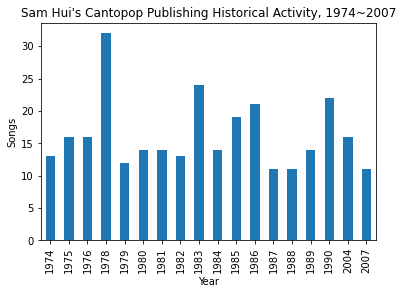

In [20]:
PivotDFinal.plot.bar(title="Sam Hui's Cantopop Publishing Historical Activity, 1974~2007", ylabel="Songs",legend=False)

It's obvious that we will need to customise our pivot functions in order to gain more useful insights.

<h3>ChatGPT-based Distant Reading</h3>

I can efficiently categorise songs by asking ChatGPT, one of the most powerful NLP tool yet, to sort the songs by two dimensions: tone and theme.

1. Tone (String, "Positive"/"Sarcastic"/"Negative")
    
    This allows me to identify the patterns Sam Hui selected his songs by.

2. Theme (String, "Hong Kong"/"Romance"/"Personal"/"Others")

    This allows me to quickly sort songs into my own observed thematic clusters.

Prompt

    Do you mind categorising the following lyrics by tone and by theme respectively, in the format of "[tone];[theme]"? The possible tones will only be "Positive", "Sarcastic", or "Negative"; while the only possible themes will be "Hong Kong", "Romance", "Personal", and "Others".

Temperature
 
    3

The low temperature is set to prevent ChatGPT from generating new categories on its own.

In [ ]:
Poe = [] #This is where we'll store the responses from ChatGPT! (Rip I ran out of time so computer-assisted manual webscraping go brrr)

search_terms = [s["Song Name"] + "\n\n" + s["Lyrics"] for s in Final]

for term in search_terms:
    print(term + "\n\n-----\n\n")
    time.sleep(1)
    Poe.append(input("Poe's Response"))

DPoe = pd.DataFrame(Poe) #Saving Progress...
DPoe.to_csv('SamHui-Poe.csv',  encoding='utf_8_sig')

I have decided to only process a portion of the database as an example because I am not a masochist who loves manually copying ChatGPT's responses. (and I'm out of time to write a script for scraping it)

In [24]:
print(len(Poe)) #This is the number of queries I have manually inserted :(
DPoe = pd.DataFrame(Poe) #Saving Progress...
DPoe.to_csv('SamHui-Poe.csv',  encoding='utf_8_sig')

133


In [36]:
PFinal = copy.deepcopy(Final)

In [37]:
Pl = len(Poe)
while len(PFinal) > Pl:
    PFinal.pop()
print(len(PFinal))

133


In [38]:
PoeM = copy.deepcopy(Poe)

In [39]:
i = 0
while i < Pl:
    Res = PoeM[i].split(";")
    if Res[0] != "Positive" and Res[0] != "Sarcastic" and Res[0] != "Negative":
        Res[0] = "Positive"
    PFinal[i]["Tone"] = Res[0]
    if Res[1] != "Hong Kong" and Res[1] != "Romance" and Res[1] != "Personal" and Res[1] != "Others":
        Res[1] = "Others"
    PFinal[i]["Theme"] = Res[1]
    i += 1

In [40]:
DPFinal = pd.DataFrame(PFinal) #Saving Progress...
DPFinal.to_csv('SamHui-Catalog-Poe.csv',  encoding='utf_8_sig')

In [42]:
PivotDPFinal = pd.pivot_table(DPFinal, index="Year", columns=["Tone","Theme"], values="Song Name", aggfunc="count", fill_value=0)
PivotDPFinal

Tone   Negative                          Positive                          \
Theme Hong Kong Others Personal Romance Hong Kong Others Personal Romance   
Year                                                                        
1974          2      0        1       3         0      0        0       4   
1975          1      1        2       3         1      0        1       1   
1976          2      1        2       3         2      0        1       1   
1978          2      4        2       1         1      3        5       5   
1979          2      1        1       3         0      2        1       2   
1980          3      0        3       0         0      2        1       2   
1981          0      1        2       0         0      3        2       3   
1982          0      0        0       1         1      2        2       5   
1983          1      0        1       5         1      3        4       7   
1984          0      0        0       0         0      0        0       2   

Tone  Sarcastic          
Theme    Others Romance  
Year                     
1974          1       0  
1975          2       0  
1976          0       0  
1978          2       0  
1979          0       0  
1980          1       0  
1981          1       0  
1982          0       0  
1983          0       2  
1984          0       0

<AxesSubplot:title={'center':"Sam Hui's Cantopop Tones & Themes, 1974~1983"}, xlabel='Year', ylabel='Songs'>

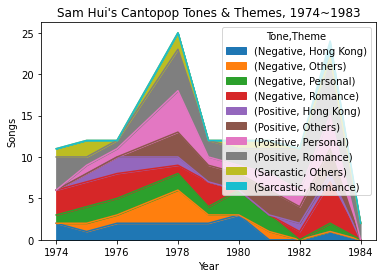

In [57]:
PivotDPFinal.plot.area(title="Sam Hui's Cantopop Tones & Themes, 1974~1983", ylabel="Songs",legend=True, stacked=True)

Considering that ChatGPT was often outrageously inaccurate in its judgement, as well as other biases (as illustrated in the Difficulties & Biases sections); I will only provide the above result as an experimental attempt at Distant Reading.

However, perhaps an investigation into why certain themes or tones spiked in a certain year, eg. the alleged decline of negative romantic songs between 1978 and 1982 and its subsequent resurgence, could be a promising start.

In particular, note how Sam Hui halted his negative social commentary after 1980, perhaps due to an improvement in social environment or him being more successful such that it might no longer be appropriate for him to empathise with common workers. 

However, 1983 also saw a brief resurgence of social commentary, probably provoked by pessimism invoked by the Sino-British negotiations over the Question of Hong Kong.

In [ ]:
i = 0 #Citing examples for the above claim
while i < Pl:
    if PFinal[i]["Theme"] == "Hong Kong" and PFinal[i]["Year"] == 1983:
        print(PFinal[i]["Album Name"], PFinal[i]["Song Name"], PFinal[i]["Tone"], PFinal[i]["Theme"])
        print(PFinal[i]["Lyrics"])
        print("------")
    i += 1

Upon Close Reading, one may notice that Sam Hui also shifted his style from earlier sarcasm and satires to more serious and heartfelt accounts. This may also be related to the global decline of hippie culture after the 1970s. 

By my friend's advice (Lecheng Li, Personal Conversation, 2023), I will also include seperate graph on tonal and thematic changes.

<AxesSubplot:title={'center':"Sam Hui's Cantopop Tones, 1974~1983"}, xlabel='Year', ylabel='Songs'>

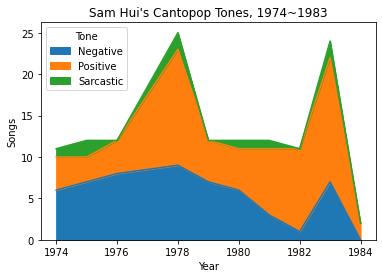

In [58]:
PivotDPFinalTo = pd.pivot_table(DPFinal, index="Year", columns="Tone", values="Song Name", aggfunc="count", fill_value=0)
PivotDPFinalTo.plot.area(title="Sam Hui's Cantopop Tones, 1974~1983", ylabel="Songs",legend=True, stacked=True)

Unsurprisingly he seemed to perform less negative songs when he was at the peak of his career around 1978~1982.

<AxesSubplot:title={'center':"Sam Hui's Cantopop Themes, 1974~1983"}, xlabel='Year', ylabel='Songs'>

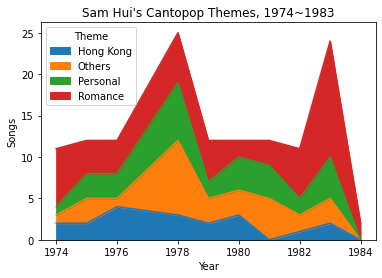

In [59]:
PivotDPFinalTo = pd.pivot_table(DPFinal, index="Year", columns="Theme", values="Song Name", aggfunc="count", fill_value=0)
PivotDPFinalTo.plot.area(title="Sam Hui's Cantopop Themes, 1974~1983", ylabel="Songs",legend=True, stacked=True)

This is actually in line with my own personal observation on how Sam Hui shifted towards the more mainstream romantic cantopop of the 1980s.

Beyond that, perhaps a focus on motivational songs between 1978 and 1982 can also be highlighted here.

In [118]:
PivotDPFinalRL = pd.pivot_table(DPFinal, index=["Record Label(s)","Year"], columns=["Tone","Theme"], values="Song Name", aggfunc="count", fill_value=0)
PivotDPFinalRL

Tone                  Negative                          Positive         \
Theme                Hong Kong Others Personal Romance Hong Kong Others   
Record Label(s) Year                                                      
寶麗多             1974         2      0        1       3         0      0   
                1975         1      1        2       3         1      0   
                1976         2      1        2       3         2      0   
                1978         2      4        2       1         1      3   
                1979         2      1        1       3         0      2   
                1980         3      0        3       0         0      2   
                1981         0      1        2       0         0      3   
                1982         0      0        0       1         1      2   
                1983         0      0        1       2         0      0   
康藝成音            1983         1      0        0       3         1      3   
                1984         0      0        0       0         0      0   

Tone                                  Sarcastic          
Theme                Personal Romance    Others Romance  
Record Label(s) Year                                     
寶麗多             1974        0       4         1       0  
                1975        1       1         2       0  
                1976        1       1         0       0  
                1978        5       5         2       0  
                1979        1       2         0       0  
                1980        1       2         1       0  
                1981        2       3         1       0  
                1982        2       5         0       0  
                1983        1       7         0       1  
康藝成音            1983        3       0         0       1  
                1984        0       2         0       0

<AxesSubplot:title={'center':"Sam Hui's Cantopop Tones & Themes with Record Labels, 1974~1983"}, xlabel='Record Label(s),Year', ylabel='Songs'>

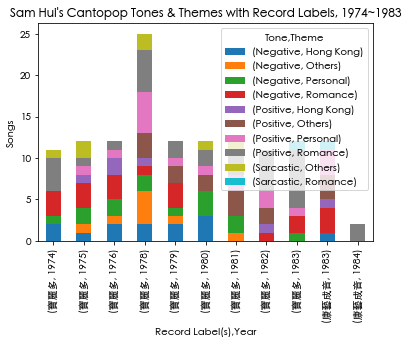

In [120]:
PivotDPFinalRL.plot.bar(title="Sam Hui's Cantopop Tones & Themes with Record Labels, 1974~1983", ylabel="Songs",legend=True, stacked=True)

According to this graph, the Record Labels had limited influence on Sam Hui's lyrical style.

In [122]:
PivotDPFinalAb = pd.pivot_table(DPFinal, index=["Year","Album Name"], columns=["Tone","Theme"], values="Song Name", aggfunc="count", fill_value=0)
PivotDPFinalAb

Tone             Negative                          Positive                  \
Theme           Hong Kong Others Personal Romance Hong Kong Others Personal   
Year Album Name                                                               
1974 鬼馬雙星               2      0        1       3         0      0        0   
1975 天才與白痴              1      1        2       3         1      0        1   
1976 半斤八兩               2      1        2       3         2      0        1   
1978 財神到                1      2        2       0         1      0        0   
     賣身契                1      2        0       1         0      3        5   
1979 '79 夏日之歌集          2      1        1       3         0      2        1   
1980 念奴嬌                3      0        3       0         0      2        1   
1981 摩登保鑣               0      1        2       0         0      3        2   
1982 難忘您·紙船             0      0        0       1         1      2        2   
1983 新的開始               1      0        0       3         1      3        3   
     最佳拍檔之大顯神通          0      0        1       2         0      0        1   
1984 最喜歡你               0      0        0       0         0      0        0   

Tone                    Sarcastic          
Theme           Romance    Others Romance  
Year Album Name                            
1974 鬼馬雙星             4         1       0  
1975 天才與白痴            1         2       0  
1976 半斤八兩             1         0       0  
1978 財神到              4         2       0  
     賣身契              1         0       0  
1979 '79 夏日之歌集        2         0       0  
1980 念奴嬌              2         1       0  
1981 摩登保鑣             3         1       0  
1982 難忘您·紙船           5         0       0  
1983 新的開始             0         0       1  
     最佳拍檔之大顯神通        7         0       1  
1984 最喜歡你             2         0       0

<AxesSubplot:title={'center':"Sam Hui's Album Tonal & Thematic Composition, 1974~1983"}, xlabel='Year,Album Name', ylabel='Songs'>

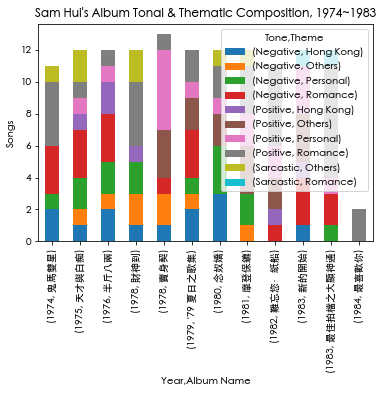

In [124]:
PivotDPFinalAb.plot.bar(title="Sam Hui's Album Tonal & Thematic Composition, 1974~1983", ylabel="Songs",legend=True, stacked=True)

According to this graph, Sam Hui's shift in style is usually continuous between albums (念奴嬌 is probably just significantly miscategorised by ChatGPT), except in 1983's 新的開始 for obvious reasons.

This particular view can also help suggest miscategorisations by showing discrepencies between album titles and music styles.

<h3>Voyant-based Macroanalysis</h3>

Next, perhaps a analysis into word frequency trends may also reveal Sam Hui's thematic preferences over time.

In [ ]:
i = 0 #Generating a .txt file for Voyant
l = len(Final)
while i < l:
    print(Final[i]["Lyrics"] + "\n\n")
    i += 1

<img src="results/macroanalysis 1.png">

By selecting significant keywords which I find significant fluctuations in, you can tell that 錢, a keyword for social commentary, peaked only at 10% and 80% of all lyrics (note that the Extended Play songs begin at around 80% such that it still refers to the same 1970s as the 10%). On the other hand, romantic words like 你, 我, or 愛 peaked around the 1980s section.

However, the trend of 錢 can also be attributed to its extreme frequent usage in the 2 1970s songs 天才白痴錢錢錢 and 錢會繼續嚟.

These trends supplement our prior discoveries in Sam Hui's lyrical patterns. However, it lacks the promise of tonal analysis by the previous method.

<img src="results/macroanalysis 2.png">

A similar observation can be drawn on the contrast between the frequency of casual and formal words used throughout the corpus, indicating a potential preference for more formal lyrics and reduction in classical chinese expressions during the 1980s.

<a href="https://voyant-tools.org/?corpus=ec7eac27ecfb32ea3aef5332d94b0a31">The Voyant Page</a>

<h3>Statistics on Frequency of Lyricists by 1990: Demo on Parsing Strings</h3>

In [89]:
Lyr = [] #Note how I can easily retrieve individual names by parsing with ';'
for id in Final:
    Yr = id["Year"]
    if Yr <= 1990:
        So = id["Song Name"]
        Names = id["Lyricist(s)"].split(';')
        for Name in Names:
            Lyr.append({
                "Year": Yr,
                "Lyricist": Name,
                "Song Name": So
            })

In [90]:
print(Lyr)
DLyr = pd.DataFrame(Lyr)

[{'Year': 1974, 'Lyricist': '許冠傑', 'Song Name': '雙星情歌'}, {'Year': 1974, 'Lyricist': '許冠傑', 'Song Name': '鬼馬雙星'}, {'Year': 1974, 'Lyricist': '許冠英', 'Song Name': '甜蜜伴侶'}, {'Year': 1974, 'Lyricist': '許冠英', 'Song Name': '無情夜冷風'}, {'Year': 1974, 'Lyricist': '許冠傑', 'Song Name': '一水隔天涯／愛你三百六十年'}, {'Year': 1974, 'Lyricist': '左几', 'Song Name': '一水隔天涯／愛你三百六十年'}, {'Year': 1974, 'Lyricist': '黃霑', 'Song Name': '一水隔天涯／愛你三百六十年'}, {'Year': 1974, 'Lyricist': '許冠傑', 'Song Name': '春夢良宵'}, {'Year': 1974, 'Lyricist': '許冠傑', 'Song Name': '制水歌'}, {'Year': 1974, 'Lyricist': '許冠傑', 'Song Name': '等玉人'}, {'Year': 1974, 'Lyricist': '許冠文', 'Song Name': '鐵塔凌雲'}, {'Year': 1974, 'Lyricist': '許冠英', 'Song Name': '夜雨聲'}, {'Year': 1974, 'Lyricist': '許冠傑', 'Song Name': '雙星情歌(音樂)'}, {'Year': 1975, 'Lyricist': '許冠傑', 'Song Name': '天才與白痴'}, {'Year': 1975, 'Lyricist': '薛志雄', 'Song Name': '天才與白痴'}, {'Year': 1975, 'Lyricist': '許冠傑', 'Song Name': '天才白痴往日情'}, {'Year': 1975, 'Lyricist': '薛志雄', 'Song Name': '天才白痴往日情'}, {'Year': 197

In [107]:
PDLyr = pd.pivot_table(DLyr, index="Lyricist", columns="Year", values="Song Name", aggfunc="count", fill_value=0)


In [108]:
PDLyr

Year,1974,1975,1976,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990
Lyricist,,,,,,,,,,,,,,,,
Instrumental,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
Rankins,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
向雪懷,0,0,0,0,0,0,0,0,1,1,2,2,1,1,1,1
唐書琛,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
小美,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0
左几,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
杉山政美,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
林夕,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
林振強,0,0,0,0,0,0,0,0,2,4,4,8,2,0,0,3


In [85]:
import matplotlib
matplotlib.rcParams['font.family'] = ['Heiti TC']

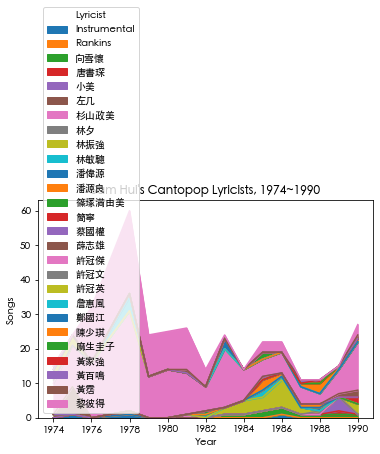

In [114]:
PivotDFinalNe = pd.pivot_table(DLyr, index="Year", columns="Lyricist", values="Song Name", aggfunc="count", fill_value=0)
x = PivotDFinalNe.plot.area(title="Sam Hui's Cantopop Lyricists, 1974~1990", ylabel="Songs",legend=True, stacked=True)

As shown above, there is a surge in non-許冠傑 and non-黎彼得 lyricists among Sam Hui's songs during the mid 1980s, which may also be indicative of future research directions.

Perhaps this is a continuation of Sam Hui's effort to divert away from his earlier style of satire and classical chinese.

<h2>Difficulties</h2>
<h3>Lack of Data Verification</h3>

Due to my lack of time for actual historical research, I am unable to fully verify all 292 data entries within the database. 

<h3>Slightly Inconsistent Formatting in Lyrics</h3>

I also had to forfeit the idea of unifying all the background vocals, often denoted by (...) in the lyrics, due to obvious time constraints.

<h3>Imperfect Data Sources</h3>

Crowd-sourced data sources like KKBox.com and Mojim.com are unreliable in nature.

While Musicbrainz (https://musicbrainz.org/artist/36ef3857-5be4-4ee0-9e8b-3280a9913a67) might be somewhat more complete for some information, its complexity deterred me from trying to scrape it for this project, instead only manually cross-referencing it for data verification.

<h3>Insufficient Ordering</h3>

Preferably I would have intentionally ordered all the names and songs, but due to time constraints I will mostly have to leave this to the default ordering. 

That being said, I suppose that the default order is soemwhat indicative of each name's significance in the composition.

The database itself is also flexible enough for each individual item to be rearranged by need.

<h3>Outrageously Inaccurate ChatGPT Judgments</h3>

Sometimes ChatGPT gives misleading categorisations (e.g. sorting 財神到 as a negative song); however, this only has a limited impact on an initial survey.

<h2>Biases</h2>

While I try to keep the base database neutral from my judgments, there are still some unavoidable biases.

<h3>Omission of Musical Components</h3>

This limits my discussion on Sam Hui's musical style from a musical standpoint.

<h3>Omission of Contextual Data</h3>

This limits the potential in drawing connections between Sam Hui, his associates, his works, and the historical context; for example, I am unable to recognise significant songs by popularity or songs, such that the analysis is catered more towards the composition rather than the reception of his music styles; I am also unable to account for relevant drama, such as his change in lyrics in 加價熱潮 due to negative responses towards the lines 

    塊面黃梗冇力 早知當初入埋英國籍 就冇有怕 冇有怕 較番外家 拜拜啦 
    
As well the song's overall connection towards the economic situation in the 1970s.

<h3>Repeated Data Entries</h3>

My lack of discrimination towards repeated releases meant that some lyrics are weighted more than others, albeit positively so as a sign of significance.

<h3>Limited Tonal and Thematic Categories</h3>

I had to overgeneralise said categories in order to make meaningful aggregations.

<h2>The Rationale (For Grading Purposes)</h2>

I presented my data analyses mainly with charts due to the significance of tracking historical changes along a time axis. Furthermore, I attempted summarising lyrics into tonal and thematic categories with ChatGPT. This is due to Sam Hui's lyrics being highly poetic such that word-by-word analysis would yield limited results.

Despite my best efforts, the database still obviously lacks actual musical data such that machines cannot effectively determine a song's tone purely through lyrics. Also, the lack of contextual data meant that we would have to draw the dots by ourselves, thereby limiting the usefulness of this database for automated analysis.

I am also unable to account for the significance of individual songs, such as 半斤八兩 or 天才與白痴 versus something like 忍, such that the analysis is catered more towards the composition rather than the reception of music styles.

Major difficulties which I have encountered during data gathering and pre-processing would mainly be the unsatisfactory qualities of lyrics available, including but not limited to inconsistent formatting and inproper characters such as o的 rather than 啲. Some songs like Top Secret is also barely available online such that I even have to personally transcribe the Cantonese-English lyrics from an audio recording.

<h2>References</h2>

Sam Hui. (2011). 許冠傑 音樂大全101 [Album]. Universal musics Ltd.

我愛你アイ・ラブ・ユー (https://www.youtube.com/watch?v=2iHA_o2iK4w), (https://www.youtube.com/watch?v=pcOqc3uTgLg), (https://ja.wikipedia.org/wiki/皇帝密使).

Top Secret (https://www.nicovideo.jp/watch/sm29443990).